/tmp/ipykernel_108155/2355708356.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_simplecnnbatch2DdataaugmentOptimisers1.pth', map

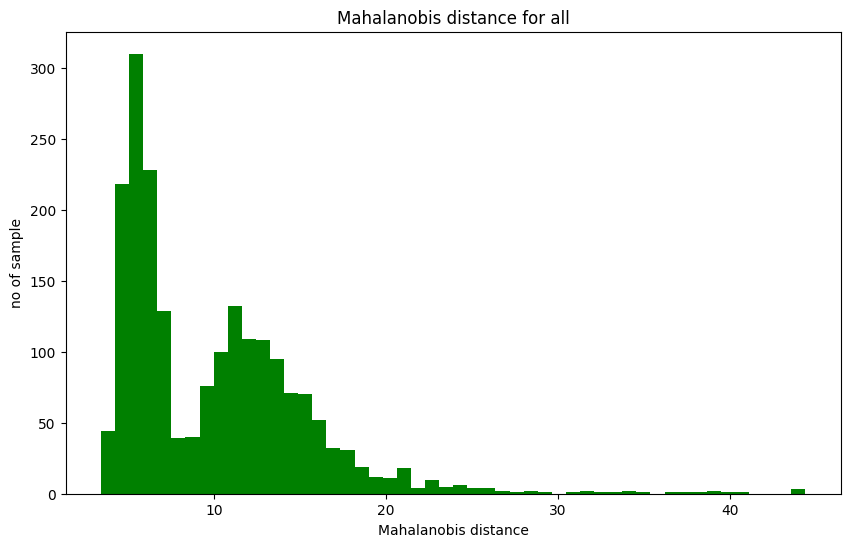

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
from sklearn.covariance import EmpiricalCovariance

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8, negative_slope=0.01):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.negative_slope = negative_slope

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=self.negative_slope))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=self.negative_slope))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=self.negative_slope))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=self.negative_slope)
        x = F.leaky_relu(self.fc2(x), negative_slope=self.negative_slope)
        x = self.fc3(x)
        return x
    
    def get_penultimate_features(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=self.negative_slope))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=self.negative_slope))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=self.negative_slope))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x), negative_slope=self.negative_slope)
        features = F.leaky_relu(self.fc2(x), negative_slope=self.negative_slope)
        return features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


num_classes = 8
model = SimpleCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('best_simplecnnbatch2DdataaugmentOptimisers1.pth', map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor()
])

all_dataset = datasets.ImageFolder('./id_odd_samples', transform=transform)
all_loader = DataLoader(all_dataset, batch_size=64, shuffle=False)


all_features = []


with torch.no_grad():
    for images, _ in all_loader:
        images = images.to(device)
        features = model.get_penultimate_features(images)
        all_features.extend(features.cpu().numpy())

all_features = np.array(all_features)


mean_vec = np.mean(all_features, axis=0)

cov = EmpiricalCovariance().fit(all_features)
inv_cov = cov.precision_

m_distances = []
for feat in all_features:
    dist = mahalanobis(feat, mean_vec, inv_cov)
    m_distances.append(dist)

m_distances = np.array(m_distances)

plt.figure(figsize=(10, 6))
plt.hist(m_distances, bins=50, color='green')
plt.xlabel('Mahalanobis distance')
plt.ylabel('no of sample')
plt.title('Mahalanobis distance for all')
plt.savefig('all_mahalanobis_distances.png')
plt.show()



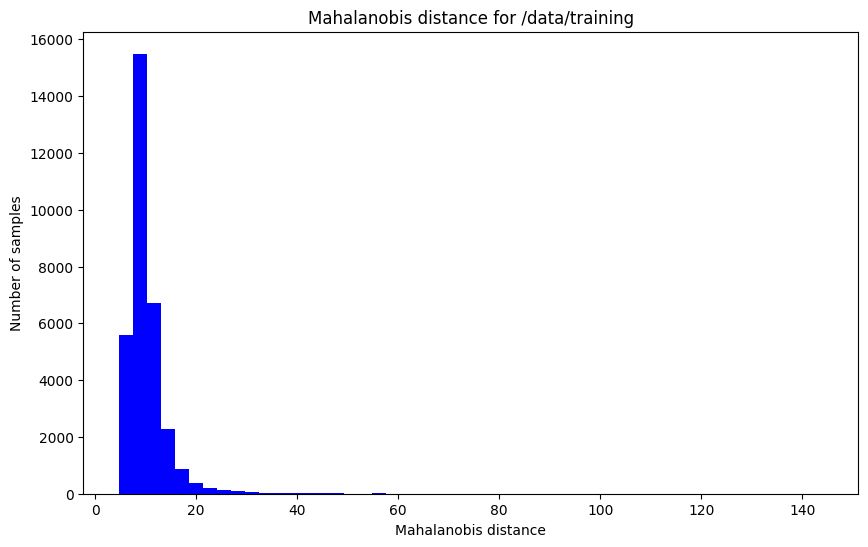

In [3]:

training_dataset = datasets.ImageFolder('./data/train', transform=transform)
training_loader = DataLoader(training_dataset, batch_size=64, shuffle=False)

training_features = []
with torch.no_grad():
    for images, _ in training_loader:
        images = images.to(device)
        features = model.get_penultimate_features(images)
        training_features.extend(features.cpu().numpy())

training_features = np.array(training_features)

training_mean_vec = np.mean(training_features, axis=0)

training_cov = EmpiricalCovariance().fit(training_features)
training_inv_cov = training_cov.precision_


training_m_distances = []
for feat in training_features:
    dist = mahalanobis(feat, training_mean_vec, training_inv_cov)
    training_m_distances.append(dist)

training_m_distances = np.array(training_m_distances)

plt.figure(figsize=(10, 6))
plt.hist(training_m_distances, bins=50, color='blue')
plt.xlabel('Mahalanobis distance')
plt.ylabel('Number of samples')
plt.title('Mahalanobis distance for /data/training')
plt.savefig('training_mahalanobis_distances.png')
plt.show()
